In [1]:
exports_dir = '../exports/en-tw-transformer-nmt/'
training_sample = 100
num_attention_layers = 4

model_plot=f'{exports_dir}/en-tw.png'
checkpoint_filepath = f'{exports_dir}/checkpoint.en-tw.weights.keras'

In [3]:
import os

os.makedirs(exports_dir, exist_ok=True)

In [68]:
import tensorflow as tf

tf.Tensor(
[[[ 0.0000000e+00  1.0000000e+00  0.0000000e+00 ...  1.0000000e+00
    0.0000000e+00  1.0000000e+00]
  [ 8.4147096e-01  5.4030228e-01  8.2185620e-01 ...  1.0000000e+00
    1.0366329e-04  1.0000000e+00]
  [ 9.0929741e-01 -4.1614684e-01  9.3641472e-01 ...  1.0000000e+00
    2.0732658e-04  1.0000000e+00]
  ...
  [ 6.1950423e-02  9.9807924e-01  7.9820567e-01 ...  9.9850446e-01
    5.2740134e-02  9.9860829e-01]
  [ 8.7332666e-01  4.8713502e-01  9.4980764e-01 ...  9.9849856e-01
    5.2843653e-02  9.9860281e-01]
  [ 8.8177037e-01 -4.7167888e-01  2.8399569e-01 ...  9.9849272e-01
    5.2947171e-02  9.9859732e-01]]], shape=(1, 512, 512), dtype=float32)
(1, 512, 512)


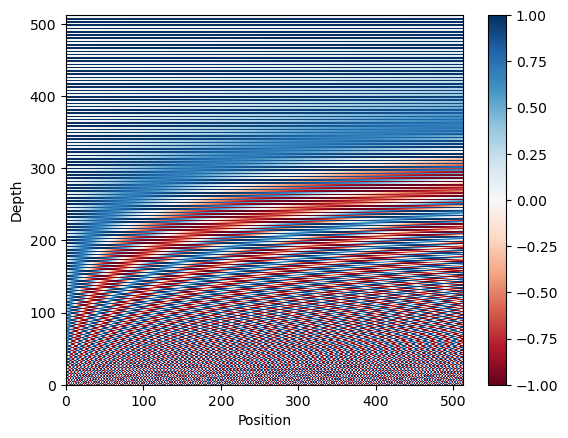

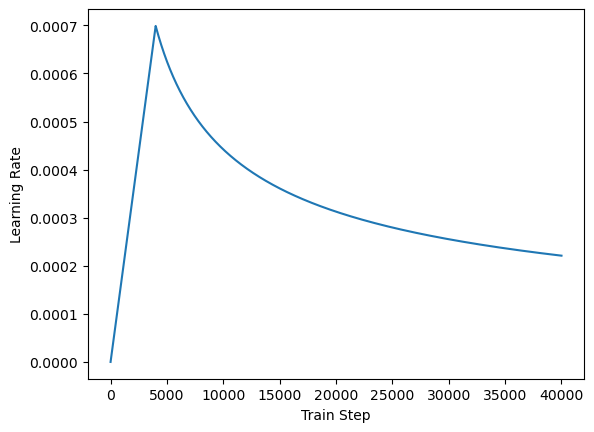

In [2]:
%run custom-layers.ipynb
%run metrics.ipynb
%run util_functions.ipynb
%run lambdas.ipynb

In [1]:
from archive.lib import loaders

inp_lang, targ_lang = loaders.en_tw(training_sample)
inp_lang.save(f"{exports_dir}")
targ_lang.save(f"{exports_dir}")
print(inp_lang, '\n', targ_lang)

NameError: name 'training_sample' is not defined

In [63]:
from keras import layers
from archive.lib.models import graph

embed_dim = 512
max_expected_user_response = 512

position_vectors = get_positional_encoding(max_seq_len=max_expected_user_response, embed_dim=embed_dim)

model = graph.Graph(
    inputs=[
        layers.Input(shape=(inp_lang.max_timesteps,), name='english_input'),
        layers.Input(shape=(targ_lang.max_timesteps,), name='twi_input')
    ],
    layers=[
        # Encoder Positional Embedding
        layers.Embedding(name='encoder_embedding', input_dim=inp_lang.vocab_size, output_dim=embed_dim, mask_zero=True),
        layers.Lambda(name='encoder_embeddings_scaled', function=tf_scale(embed_dim)),
        layers.Lambda(name='encoder_positions',
                      function=lambda x: x + position_vectors[:x.shape[0], :x.shape[1], :x.shape[2]]),

        layers.Dropout(name='encoder_dropout', rate=0.1),

        SelfAttention(name="encoder_attention", num_heads=8, key_dim=embed_dim, dropout=0.1),
        FeedForward(name="encoder_feedforward", d_model=embed_dim, dff=2048),

        # Decoder Positional Embedding
        layers.Embedding(name='decoder_embedding', input_dim=targ_lang.vocab_size, output_dim=embed_dim,
                         mask_zero=True),
        layers.Lambda(name='decoder_embeddings_scaled', function=tf_scale(embed_dim)),
        layers.Lambda(name='decoder_positions',
                      function=lambda x: x + position_vectors[:x.shape[0], :x.shape[1], :x.shape[2]]),
        layers.Add(name='decoder_embeddings_to_positions'),

        layers.Dropout(name='decoder_dropout', rate=0.1),

        MaskedSelfAttention(name="decoder_masked_attention", num_heads=8, key_dim=embed_dim, dropout=0.1),
        CrossAttention(name="decoder_cross_attention", num_heads=8, key_dim=embed_dim, dropout=0.1),
        FeedForward(name="decoder_feedforward", d_model=embed_dim, dff=2048),

        layers.Dense(targ_lang.vocab_size, activation='softmax', name='output')
    ],
    connections=[
        # Encoder
        ('english_input', 'encoder_embedding'),
        ('encoder_embedding', 'encoder_embeddings_scaled'),
        ('encoder_embeddings_scaled', 'encoder_positions'),

        ('encoder_positions', 'encoder_dropout'),
        ('encoder_dropout', 'encoder_attention'),
        ('encoder_attention', 'encoder_feedforward'),

        # Bridge - Encoder's output goes to decoder as context
        ('encoder_feedforward', 'decoder_cross_attention[context]'),

        # Decoder
        ('twi_input', 'decoder_embedding'),
        ('decoder_embedding', 'decoder_embeddings_scaled'),
        ('decoder_embeddings_scaled', 'decoder_positions'),

        ('decoder_positions', 'decoder_dropout'),
        ('decoder_dropout', 'decoder_masked_attention'),
        ('decoder_masked_attention', 'decoder_cross_attention[x]'),
        ('decoder_cross_attention', 'decoder_feedforward'),

        ('decoder_feedforward', 'output')
    ]
)

In [64]:
model.summary()

Model: "graph_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 english_input (InputLayer)  [(None, 35)]                 0         []                            
                                                                                                  
 twi_input (InputLayer)      [(None, 30)]                 0         []                            
                                                                                                  
 encoder_embedding (Embeddi  (None, 35, 512)              180224    ['english_input[0][0]']       
 ng)                                                                                              
                                                                                                  
 decoder_embedding (Embeddi  (None, 30, 512)              210944    ['twi_input[0][0]']     

In [71]:
model.load_weights(checkpoint_filepath)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'training_checkpoints/checkpoint.en-tw.weights.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [72]:
from keras import optimizers

model.compile(loss=masked_loss, optimizer=optimizers.legacy.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                                                 epsilon=1e-9))

In [73]:
from keras import callbacks

model_checkpoint_callback = callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True,
                                                      save_weights_only=True)

In [57]:
# data = inp_lang.tensor(), targ_lang.tensor(shift='start')
# model.fit(data, targ_lang.tensor(), epochs=10, validation_split=0.2, callbacks=[model_checkpoint_callback])

In [58]:
# model.save_weights(checkpoint_filepath)

In [74]:
import numpy as np
from archive.lib.models.graph import Graph


class Translator(tf.Module):
    def __init__(self, transformer: Graph):
        self.transformer = transformer

    def __call__(self, sentence, max_length=60):
        output = np.array([targ_lang.eos_token])

        for i in tf.range(1, max_length):
            decoder_input = output[np.newaxis]
            predictions = self.transformer.predict([sentence, decoder_input], batch_size=1, verbose=2)
            predictions = predictions[:, -1:, :]

            predicted_id = tf.argmax(predictions, axis=-1)

            output = np.append(output, predicted_id[0], axis=0)

            print("output", output)

            if predicted_id == targ_lang.eos_token:
                break

        print(np.shape(output[0]))
        text = targ_lang[output[0].tolist()]

        return text

In [75]:
translator = Translator(model)

In [76]:
def print_translation(sentence, tokens):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens}')

In [77]:
from archive.lib.preprocessors.naive_words import naive_words

sentence = "Lion"
sentence = naive_words(sentence, punctuations="?.!,¿'", special_chars='ɛƐɔƆ').split(' ')
sentence = inp_lang.to_padded_tensor([sentence])

print_translation(sentence, translator(sentence))

KeyError: 'lion'

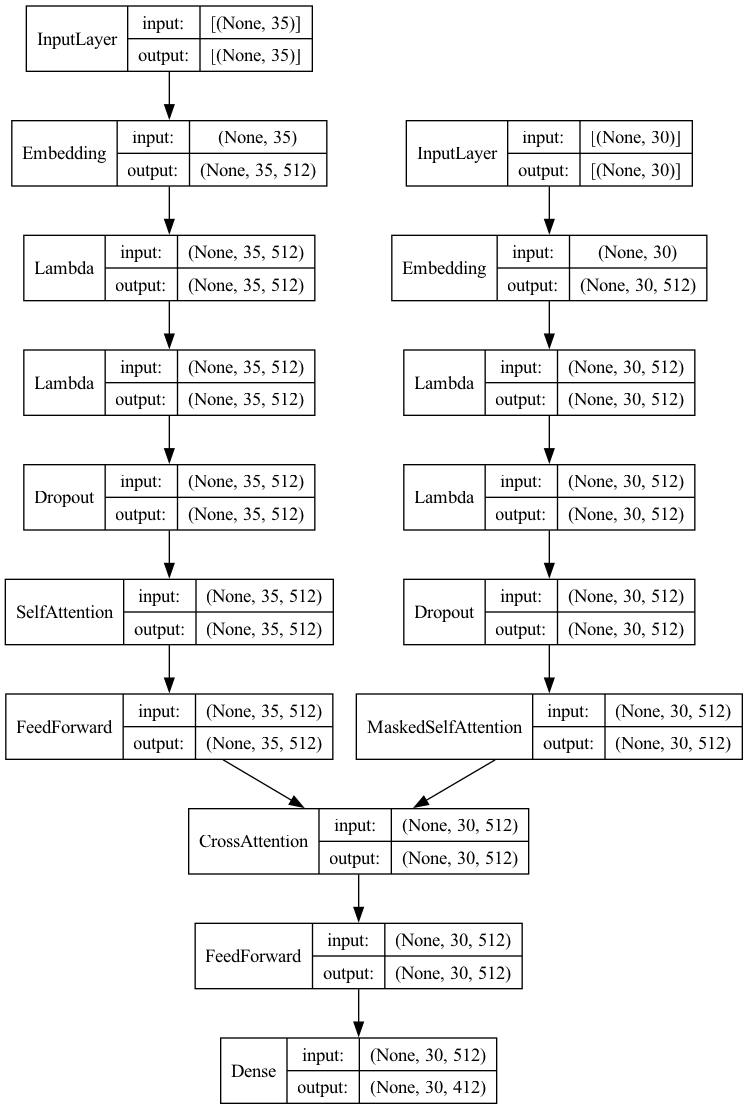

In [88]:
import keras

keras.utils.plot_model(model, to_file=f'{exports_dir}/en-tw.png', show_shapes=True, show_layer_names=False, expand_nested=True)